In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
from scipy import stats
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from joblib import Parallel, delayed
import plotly.graph_objects as go
import plotly.express as px

from dPCA import dPCA

from notebooks.imports import *
from config import dir_config, main_config, ephys_config
from src.utils import pmf_utils, plot_utils, ephys_utils
import os
os.environ["PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT"] = "2.0"


In [3]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

## Utils

In [57]:
def get_neuron_condition_trials(sessions, trial_info):
    """
    Optimized function to get neuron condition trials with reduced function calls.
    """
    neuron_condition_dict = {}
    conditions_list = [
        ("coh_0_choice_toRF_corr", (0, 1)),
        ("coh_6_choice_toRF_corr", (0.06, 1, 1)),
        ("coh_20_choice_toRF_corr", (0.2, 1, 1)),
        ("coh_50_choice_toRF_corr", (0.5, 1, 1)),
        ("coh_0_choice_awayRF_corr", (0, 0)),
        ("coh_6_choice_awayRF_corr", (0.06, 0, 1)),
        ("coh_20_choice_awayRF_corr", (0.2, 0, 1)),
        ("coh_50_choice_awayRF_corr", (0.5, 0, 1))
    ]

    for session_id in sessions:
        neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
        conditions = {key: np.array(ephys_utils.get_trial_num(trial_info[session_id], *vals)) for key, vals in conditions_list}
        
        for neuron_id in neuron_ids:
            neuron_condition_dict[neuron_id] = conditions.copy()  # Use copy to prevent reference issues

    return neuron_condition_dict

def create_pca_matrix_by_condition(neuron_condition_dict, normalize = True):
    conditions = [
        "coh_0_choice_toRF_corr",
        "coh_6_choice_toRF_corr",
        "coh_20_choice_toRF_corr",
        "coh_50_choice_toRF_corr",
        "coh_0_choice_awayRF_corr",
        "coh_6_choice_awayRF_corr",
        "coh_20_choice_awayRF_corr",
        "coh_50_choice_awayRF_corr"
        ]
    PCA_data = {event: [] for event in ephys_config["alignment_settings_GP"].keys()}
    condition_len = {event: {} for event in ephys_config["alignment_settings_GP"].keys()}    

    for alignment in ephys_config["alignment_settings_GP"].keys():
        for condition in conditions:
            time_duration = ephys_config["alignment_settings_GP"][alignment]["end_time_ms"] - ephys_config["alignment_settings_GP"][alignment]["start_time_ms"] + 1
            all_neuron_data = np.full((len(neuron_condition_dict.keys()), time_duration), np.nan)
            for neuron_idx, neuron_id in enumerate(neuron_condition_dict.keys()):        
                trials = neuron_condition_dict[neuron_id][condition]
                condition_data = ephys_utils.get_neural_data_from_trial_num(ephys[alignment][neuron_id], trials, type="convolved_spike_trains")
                if alignment == "stimulus_onset":
                    non_nan_50_prct_timepoint = np.where(np.sum(np.isnan(condition_data), axis=0)/len(trials) > 0.5)[0]
                    if non_nan_50_prct_timepoint.size==0:
                        non_nan_50_prct_timepoint = condition_data.shape[1]
                    else:
                        non_nan_50_prct_timepoint = non_nan_50_prct_timepoint[0] - 1

                    neuron_array = condition_data[:,:non_nan_50_prct_timepoint]
                    all_neuron_data[neuron_idx, :non_nan_50_prct_timepoint] = np.nanmean(neuron_array,axis=0)
            
                elif alignment == "response_onset":
                    non_nan_50_prct_timepoint = np.where(np.sum(np.isnan(condition_data), axis=0)/len(trials) > 0.5)[0]
                    if non_nan_50_prct_timepoint.size==0:
                        non_nan_50_prct_timepoint = 0
                    else:
                        non_nan_50_prct_timepoint = non_nan_50_prct_timepoint[-1] + 1
                    neuron_array = condition_data[:,non_nan_50_prct_timepoint:]
                    all_neuron_data[neuron_idx, non_nan_50_prct_timepoint:] = np.nanmean(neuron_array,axis=0)
                elif alignment == "target_onset":
                    all_neuron_data[neuron_idx,:] = np.nanmean(condition_data,axis=0)

            
            all_non_nan_mask = ~np.any(np.isnan(all_neuron_data), axis=0)
            all_neuron_data = all_neuron_data[:, all_non_nan_mask]
            PCA_data[alignment].append(all_neuron_data)
            if all_neuron_data.shape[1] == 0:
                pass
            condition_len[alignment][condition] = all_neuron_data.shape[1]

        
        PCA_data[alignment] = np.hstack(PCA_data[alignment])

        if normalize:
            scaler = StandardScaler()
            PCA_data[alignment] = scaler.fit_transform(PCA_data[alignment].T).T

    return PCA_data, condition_len

def go_scatter(fig, x, y, z=None, name=" ", color=None, markersize=2, linestyle="solid", linewidth=2, mode="lines+markers", opacity=0.8, showlegend=False):
    """Helper function to add a 2D or 3D scatter plot to a Plotly figure."""
    if z is None:
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode=mode,
            marker=dict(
                size=markersize,
                color=color if color is not None else 'black',
                opacity=opacity
            ),
            line=dict(width=linewidth, dash=linestyle),
            opacity=opacity,
            name=name,
            showlegend=showlegend
        ))
    else:
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode=mode,
            marker=dict(
                size=markersize,
                color=color if color is not None else 'black',
                opacity=opacity
            ),
            line=dict(width=linewidth, dash=linestyle),
            opacity=opacity,  
            name=name,
            showlegend=showlegend
        ))

def plot_pca_projection(fig, conditions, state_values,
                        proj_biased_mean, proj_unbiased_mean,
                        timepoints_list, onset_time, axes=(0, 1)):
    """
    Function to plot PCA projections with SEM as shaded areas.
    Now supports 2D and 3D plotting by choosing the number of axes.
    """
    condition_dict = {
        "coh_0_choice_toRF_corr": {"index": 0, "color": "blue", "biased_lw": 5, "unbiased_lw": 2, "opacity": 1},
        "coh_6_choice_toRF_corr": {"index": 1, "color": "green", "biased_lw": 5, "unbiased_lw": 2, "opacity": 1},
        "coh_20_choice_toRF_corr": {"index": 2, "color": "orange", "biased_lw": 5, "unbiased_lw": 2, "opacity":1},
        "coh_50_choice_toRF_corr": {"index": 3, "color": "red", "biased_lw": 5, "unbiased_lw": 2, "opacity": 1},
        "coh_0_choice_awayRF_corr": {"index": 4, "color": "blue", "biased_lw": 5, "unbiased_lw": 2, "opacity": 0.3},
        "coh_6_choice_awayRF_corr": {"index": 5, "color": "green", "biased_lw": 5, "unbiased_lw": 2, "opacity": 0.3},
        "coh_20_choice_awayRF_corr": {"index": 6, "color": "orange", "biased_lw": 5, "unbiased_lw": 2, "opacity": 0.3},
        "coh_50_choice_awayRF_corr": {"index": 7, "color": "red", "biased_lw": 5, "unbiased_lw": 2, "opacity": 0.3},
    }

    for condition in conditions:
        condition_params = condition_dict[condition]  # Extract plotting parameters
        # condition = condition_params["index"]
        
        for state in state_values:
            name = f"{condition}_{state}"
            # Select mean and parameters
            if state == "biased_state":
                mean = proj_biased_mean[condition]
                linewidth = condition_params["biased_lw"]
            else:
                mean = proj_unbiased_mean[condition]
                linewidth = condition_params["unbiased_lw"]

            # Plot using the selected axes
            if len(axes) == 2:
                go_scatter(fig, mean[axes[0]], mean[axes[1]], 
                           name=name, color=condition_params["color"], 
                           mode="lines", linewidth=linewidth, opacity=condition_params["opacity"],showlegend=True)
            elif len(axes) == 3:
                go_scatter(fig, mean[axes[0]], mean[axes[1]], mean[axes[2]],
                           name=name, color=condition_params["color"], 
                           mode="lines", linewidth=linewidth, opacity=condition_params["opacity"],showlegend=True)

    # Highlight key time points
    for idx, timepoint in enumerate(timepoints_list):
        for condition in conditions:
            condition_params = condition_dict[condition]
            
            for state in state_values:
                marker_size = 8 if idx == 0 else 5
                if state == "biased_state":
                    if ~np.all(np.isnan(proj_biased_mean[condition][:,timepoint])):
                        x, y = proj_biased_mean[condition][axes[0], timepoint], proj_biased_mean[condition][axes[1], timepoint]
                        z = proj_biased_mean[condition][axes[2], timepoint] if len(axes) == 3 else None
                        go_scatter(fig, [x], [y], [z] if z is not None else None,
                           color="black", markersize=marker_size, mode="markers")
                else:
                    if ~np.all(np.isnan(proj_unbiased_mean[condition][:,timepoint])):
                        x, y = proj_unbiased_mean[condition][axes[0], timepoint], proj_unbiased_mean[condition][axes[1], timepoint]
                        z = proj_unbiased_mean[condition][axes[2], timepoint] if len(axes) == 3 else None 
                        go_scatter(fig, [x], [y], [z] if z is not None else None,
                           color="black", markersize=marker_size, mode="markers")

    # Mark onset time with violet dots
    for condition in conditions:
        condition_params = condition_dict[condition]
        # condition = condition_params["index"]
        
        for state in state_values:
            if state == "biased_state":
                if ~np.all(np.isnan(proj_biased_mean[condition][:,onset_time])):
                    x, y = proj_biased_mean[condition][axes[0], onset_time], proj_biased_mean[condition][axes[1], onset_time]
                    z = proj_biased_mean[condition][axes[2], onset_time] if len(axes) == 3 else None
                    go_scatter(fig, [x], [y], [z] if z is not None else None,
                       color="violet", markersize=10, mode="markers")
            else:
                if ~np.all(np.isnan(proj_unbiased_mean[condition][:,onset_time])):
                    x, y = proj_unbiased_mean[condition][axes[0], onset_time], proj_unbiased_mean[condition][axes[1], onset_time]
                    z = proj_unbiased_mean[condition][axes[2], onset_time] if len(axes) == 3 else None
                    go_scatter(fig, [x], [y], [z] if z is not None else None,
                       color="violet", markersize=10, mode="markers")
                    
    go_scatter(fig,[None],[None],[None] if len(axes) == 3 else None, name="Onset Time", color="violet", markersize=10, mode="markers", showlegend=True)
    go_scatter(fig,[None],[None],[None] if len(axes) == 3 else None, name=f"{timepoints_list[1]-timepoints_list[0]}ms spacing", color="black", markersize=8, mode="markers", showlegend=True)

def plot_pca_projection_and_sem(fig, conditions, state_values,
                        proj_biased_mean, proj_unbiased_mean,
                        proj_biased_std, proj_unbiased_std,
                        timepoints_list, onset_time, axes=(0, 1)):
    """
    Function to plot PCA projections with Mean and Std as shaded areas.
    Supports both 2D and 3D plotting.
    """
    condition_dict = {
        "coh_0_choice_toRF_corr": {"color": "blue", "opacity": 1},
        "coh_6_choice_toRF_corr": {"color": "green", "opacity": 1},
        "coh_20_choice_toRF_corr": {"color": "orange", "opacity": 1},
        "coh_50_choice_toRF_corr": {"color": "red", "opacity": 1},
        "coh_0_choice_awayRF_corr": {"color": "blue", "opacity": 0.3},
        "coh_6_choice_awayRF_corr": {"color": "green", "opacity": 0.3},
        "coh_20_choice_awayRF_corr": {"color": "orange", "opacity": 0.3},
        "coh_50_choice_awayRF_corr": {"color": "red", "opacity": 0.3},
    }
    
    for condition in conditions:
        condition_params = condition_dict[condition]
        color = condition_params["color"]
        opacity = condition_params["opacity"]
        
        for state in state_values:
            name = f"{condition}_{state}"
            
            if state == "biased_state":
                mean = proj_biased_mean[condition]
                std = proj_biased_std[condition]
            else:
                mean = proj_unbiased_mean[condition]
                std = proj_unbiased_std[condition]
            if len(axes) == 2:
                valid_mask = ~np.isnan(mean[axes[0]]) & ~np.isnan(std[axes[0]]) & ~np.isnan(mean[axes[1]]) & ~np.isnan(std[axes[1]])
                # Plot mean
                go_scatter(fig, mean[axes[0]][valid_mask], mean[axes[1]][valid_mask], 
                           name=name, color=color, mode="lines", linewidth=2, opacity=opacity, showlegend=True)
                # Plot standard deviation as shaded area
                x_valid = np.concatenate([
                    (mean[axes[0]][valid_mask] + std[axes[0]][valid_mask]*5), 
                    (mean[axes[0]][valid_mask] - std[axes[0]][valid_mask]*5)[::-1]])
                y_valid = np.concatenate([
                    (mean[axes[1]][valid_mask] + std[axes[1]][valid_mask]*5), 
                    (mean[axes[1]][valid_mask] - std[axes[1]][valid_mask]*5)[::-1]])
                fig.add_trace(go.Scatter(
                    x=x_valid, 
                    y=y_valid,
                    fill='toself',
                    fillcolor=color,
                    opacity=0.2,
                    line=dict(width=0),
                    showlegend=False,
                    name=f"{name}_std"
                ))

            elif len(axes) == 3:
                # Plot mean
                go_scatter(fig, mean[axes[0]], mean[axes[1]], mean[axes[2]],
                           name=name, color=color, mode="lines", linewidth=2, opacity=opacity, showlegend=True)
                # Plot standard deviation as lines (shading is not directly possible in 3D)
                for std_offset in [-1, 1]:
                # Offset for all three axes
                    go_scatter(fig, 
                            mean[axes[0]] + std_offset * std[axes[0]],  # X with std
                            mean[axes[1]] + std_offset * std[axes[1]],  # Y with std
                            mean[axes[2]] + std_offset * std[axes[2]],  # Z with std
                            name=f"{name}_std", color=color, mode="lines", opacity=0.2, showlegend=False)

    # Highlight key time points
    for idx, timepoint in enumerate(timepoints_list):
        for condition in conditions:
            condition_params = condition_dict[condition]
            
            for state in state_values:
                marker_size = 8 if idx == 0 else 5
                if state == "biased_state":
                    if ~np.all(np.isnan(proj_biased_mean[condition][:,timepoint])):
                        x, y = proj_biased_mean[condition][axes[0], timepoint], proj_biased_mean[condition][axes[1], timepoint]
                        z = proj_biased_mean[condition][axes[2], timepoint] if len(axes) == 3 else None
                        go_scatter(fig, [x], [y], [z] if z is not None else None,
                           color="black", markersize=marker_size, mode="markers")
                else:
                    if ~np.all(np.isnan(proj_unbiased_mean[condition][:,timepoint])):
                        x, y = proj_unbiased_mean[condition][axes[0], timepoint], proj_unbiased_mean[condition][axes[1], timepoint]
                        z = proj_unbiased_mean[condition][axes[2], timepoint] if len(axes) == 3 else None 
                        go_scatter(fig, [x], [y], [z] if z is not None else None,
                           color="black", markersize=marker_size, mode="markers")
                        
    # Mark onset time with violet dots
    for condition in conditions:
        for state in state_values:
            if state == "biased_state":
                mean = proj_biased_mean[condition]
            else:
                mean = proj_unbiased_mean[condition]
            
            if ~np.all(np.isnan(mean[:, onset_time])):
                x, y = mean[axes[0], onset_time], mean[axes[1], onset_time]
                z = mean[axes[2], onset_time] if len(axes) == 3 else None
                go_scatter(fig, [x], [y], [z] if z is not None else None,
                           color="violet", markersize=10, mode="markers")
    
    go_scatter(fig,[None],[None],[None] if len(axes) == 3 else None, name="Onset Time", color="violet", markersize=10, mode="markers", showlegend=True)
    go_scatter(fig,[None],[None],[None] if len(axes) == 3 else None, name=f"{timepoints_list[1]-timepoints_list[0]}ms spacing", color="black", markersize=8, mode="markers", showlegend=True)

def split_array_by_cond(data, array_lengths,alignment):
    duration = ephys_config["alignment_settings_GP"][alignment]["end_time_ms"] - ephys_config["alignment_settings_GP"][alignment]["start_time_ms"] + 1
    split_arrays = {key: np.full((3,duration), np.nan) for key in array_lengths.keys()}
    start_idx = 0
    # print(array_lengths)
    for key, length in array_lengths.items():        
        end_idx = start_idx + length
        # print(start_idx, end_idx)

        if alignment == "response_onset":
            split_arrays[key][:,-(end_idx-start_idx):] = data[:, start_idx:end_idx]
        else:
            split_arrays[key][:,:(end_idx-start_idx)] = data[:, start_idx:end_idx]
        start_idx = end_idx
    return split_arrays

def dpca_transform(dpca, X):    
    X = X - np.nanmean(X.reshape((X.shape[0],-1)),1).reshape((X.shape[0],) + (len(X.shape)-1)*(1,))
    total_variance = np.sum((X - np.nanmean(X))**2)
    def marginal_variances(marginal):
        ''' Computes the relative variance explained of each component
            within a marginalization
        '''
        D, Xr = dpca.D[marginal], X.reshape((X.shape[0],-1))
        return [np.sum(np.dot(D[:,k], Xr)**2) / total_variance for k in range(D.shape[1])]
    
    X_transformed = {}
    dpca.explained_variance_ratio_ = {}
    for key in list(dpca.marginalizations.keys()):
        X_transformed[key] = np.dot(dpca.D[key].T, X.reshape((X.shape[0],-1))).reshape((dpca.D[key].shape[1],) + X.shape[1:])
        dpca.explained_variance_ratio_[key] = marginal_variances(key)
    return dpca, X_transformed

def create_dpca_matrix(sessions, condition_dict, session_neuron_ids, trial_info):
    n_neurons = len(session_neuron_ids)
    n_coherences = len(condition_dict["coherences"])
    n_choices = len(condition_dict["choices"])
    dPCA_averaged_data = {event: np.full([n_neurons, n_coherences, n_choices, 
                                 ephys_config["alignment_settings_GP"][event]["end_time_ms"] -ephys_config["alignment_settings_GP"][event]["start_time_ms"]+1], np.nan) 
                                 for event in ephys_config["alignment_settings_GP"].keys()}
    dPCA_trial_wise_data = {event: np.full([500, n_neurons, n_coherences, n_choices, 
                                 ephys_config["alignment_settings_GP"][event]["end_time_ms"] -ephys_config["alignment_settings_GP"][event]["start_time_ms"]+1], np.nan) 
                                 for event in ephys_config["alignment_settings_GP"].keys()}
    
    for alignment in ephys_config["alignment_settings_GP"].keys():
        for session_id in sessions:
            # get neurons in this session
            neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
            # extract trial numbers for each condition
            for coherence_idx, coherence in enumerate(condition_dict["coherences"]):
                for choice_idx, choice in enumerate(condition_dict["choices"]):
                    trials = ephys_utils.get_trial_num(trial_info[session_id], coherence=coherence, choice=choice_idx, outcome=1)

                    for neuron_id in neuron_ids:
                        trial_wise_data = ephys_utils.get_neural_data_from_trial_num(ephys[alignment][neuron_id], trials, type="convolved_spike_trains")                            
                        if trial_wise_data.shape[0] == 0:
                            print(f"No trials found in Session: {session_id}, Neuron: {neuron_id}, condition: {coherence, choice}")
                            continue
                        averaged_data = np.nanmean(trial_wise_data, axis=0)
                            
                        if alignment == "stimulus_onset":
                            non_nan_timepoint = np.where(np.sum(np.isnan(trial_wise_data), axis=0)/len(trials) <= 0.7)[0]
                            averaged_data = averaged_data[:non_nan_timepoint[-1] + 1]
                            dPCA_averaged_data[alignment][np.where(session_neuron_ids == neuron_id)[0], coherence_idx, choice_idx, 0:len(averaged_data)] = averaged_data
                        elif alignment == "response_onset":
                            non_nan_timepoint = np.where(np.sum(np.isnan(trial_wise_data), axis=0)/len(trials) <= 0.7)[0]
                            averaged_data = averaged_data[non_nan_timepoint[0]:]
                            dPCA_averaged_data[alignment][np.where(session_neuron_ids == neuron_id)[0], coherence_idx, choice_idx, -len(averaged_data):] = averaged_data
                        else:
                            dPCA_averaged_data[alignment][np.where(session_neuron_ids == neuron_id)[0], coherence_idx, choice_idx, :] = averaged_data

                        dPCA_trial_wise_data[alignment][:trial_wise_data.shape[0], np.where(session_neuron_ids == neuron_id)[0], coherence_idx, choice_idx, :] = np.expand_dims(trial_wise_data, axis=1)
                                
    return dPCA_averaged_data, dPCA_trial_wise_data

def plot_component(ax, time, data, title, plot_mean=False, sig_mask=None, axes_to_loop=None, color=None, linestyle=None):
    # Default axes to loop over if not provided (all axes: b, s, and c)
    if axes_to_loop is None:
        axes_to_loop = marginalization_keys[:-1]  # Loop over all axes: bias (b), stimulus (s), and choice (c)
    axis_indices = {marg: marg_idx for marg_idx,marg in enumerate(marginalization_keys[:-1])}
    axes_not_to_loop = [axis_indices[axis] for axis in axis_indices if axis not in axes_to_loop]


    # Loop over the specified axes (b, s, c)
    for s in range(4) if 's' in axes_to_loop else [0]: 
        for c in range(2) if 'c' in axes_to_loop else [0]:
            # If we are not plotting the mean, plot the raw data
            if not plot_mean:
                ax.plot(
                    time,
                    np.squeeze(data[s, c, :]),  # Raw data
                    color=plot_params["color"][s] if color is None else color,
                    linestyle=plot_params["linestyle"][c] if linestyle is None else linestyle,
                )
            else:
                axes = {'s': s, 'c': c}
                indices = [axes[axis] if axis in axes_to_loop else slice(None) for axis in axis_indices]
                mean_data = np.mean(np.squeeze(data[*indices, :]), axis=tuple(range(len(axes_not_to_loop))))
                ax.plot(
                    time,
                    mean_data,  # Plot the mean over the non-looped axes
                    color=plot_params["color"][s] if color is None else color,
                    linestyle=plot_params["linestyle"][c] if linestyle is None else linestyle,
                )
            
            lower_ylim = np.amin(data)-((np.amax(data) - np.amin(data))*0.05)-0.05
            upper_ylim = np.amax(data) + ((np.amax(data) - np.amin(data))*0.05)+0.05
            if sig_mask is not None:
                ax.imshow(sig_mask, extent=[time[0], time[-1], lower_ylim, np.amin(data)-0.05], aspect='auto', cmap='gray_r', vmin=0, vmax=1)
            ax.set_title(title)
            ax.set_ylim(lower_ylim, upper_ylim)
            ax.axvline(0, color="black", linestyle="--", linewidth=1)

def plot_dPCA_projection(plot_mean, prior, state, ephys_config, dpca_results):
    alignment_dict = ephys_config["alignment_settings_GP"]
    print(f"Prior: {prior.split('_')[0]}, State: {state.split('_')[0]}")
    for alignment in alignment_dict.keys():
        # Get transformed data
        Z = dpca_results[prior][state][alignment]["transformed_data"]
        
        # Align the duration based on the alignment type
        aligned_duration = np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"] + 1)
        time = aligned_duration[-np.arange(Z['t'].shape[-1]) - 1][::-1] if alignment == "response_onset" else aligned_duration[np.arange(Z['t'].shape[-1])]
        # Set step size based on alignment type
        step = 50 if alignment == "response_onset" else 100
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Loop through the principal components (PCs)
        for PC_num in range(2):
            # Plot each component depending on whether mean is requested
            if plot_mean:
                plot_component(axes[PC_num, 0], time, Z['t'][PC_num,:], f"time PC {PC_num+1}")
                plot_component(axes[PC_num, 1], time, Z['s'][PC_num, :], f"stimulus PC {PC_num+1}", plot_mean=True, axes_to_loop=['s'], linestyle=plot_params["linestyle"][0])
                plot_component(axes[PC_num, 2], time, Z['c'][PC_num, :], f"choice PC {PC_num+1}", plot_mean=True, axes_to_loop=['c'],color='k')
            else:
                plot_component(axes[PC_num, 0], time, Z['t'][PC_num,:], f"time PC {PC_num+1}")
                plot_component(axes[PC_num, 1], time, Z['s'][PC_num,:], f"stimulus PC {PC_num+1}")
                plot_component(axes[PC_num, 2], time, Z['c'][PC_num,:], f"choice PC {PC_num+1}")

        # Add the legend for different lines
        handles = [
            plt.Line2D([0], [0], color="red", label="50% coh"),
            plt.Line2D([0], [0], color="orange", label="20% coh"),
            plt.Line2D([0], [0], color="green", label="6% coh"),
            plt.Line2D([0], [0], color="blue", label="0% coh"),
            plt.Line2D([0], [0], color='k', alpha=1, label="biased state"),
            plt.Line2D([0], [0], color='k', alpha=0.3, label="unbiased state"),
            plt.Line2D([0], [0], color='k', linestyle="-", label="toRF choice"),
            plt.Line2D([0], [0], color='k', linestyle="--", label="awayRF choice"),
        ]
        fig.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper right')
        fig.suptitle(f"Aligned to {alignment.capitalize().replace('_', ' ')}")
        plt.show()

## Load Data

In [5]:
session_to_exclude = ["210210_GP_JP","241209_GP_TZ"]

session_metadata = pd.read_csv(Path(compiled_dir, 'sessions_metadata.csv'))
session_metadata = session_metadata[~np.isin(session_metadata["session_id"],session_to_exclude)] 

neuron_metadata = pd.read_csv(Path(compiled_dir, 'neuron_metadata.csv'))
neuron_metadata = neuron_metadata[~np.isin(neuron_metadata["session_id"],session_to_exclude)]

with open(Path(processed_dir, f'glm_hmm_all_trials_prior_based_initialization_final.pkl'), 'rb') as f:
    glm_hmm = pickle.load(f)

with open(Path(processed_dir, f'ephys_neuron_wise.pkl'), 'rb') as f:
    ephys = pickle.load(f)

## Extract biased and unbiased states, toRF and awayRF prior sessions

In [6]:
toRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "toRF"]
awayRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "awayRF"]

# extract neuron_id for each toRF session
toRF_neuron_ids = np.array([])
for session_id in toRF_sessions:
    neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
    toRF_neuron_ids = np.append(toRF_neuron_ids,neuron_ids)

# extract neuron_id for each awayRF session
awayRF_neuron_ids = np.array([])
for session_id in awayRF_sessions:
    neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
    awayRF_neuron_ids = np.append(awayRF_neuron_ids,neuron_ids)

In [7]:
state_occupancy = {}
biased_state_trial_info = {}
unbiased_state_trial_info = {}
for idx_session, session_id in enumerate(glm_hmm["session_wise"]["data"]):
    model = glm_hmm["session_wise"]["models"][session_id]
    choices = glm_hmm["session_wise"]["data"][session_id]["choices"].values.reshape(-1, 1)
    input = np.array(glm_hmm["session_wise"]["data"][session_id][["normalized_stimulus","bias","previous_choice","previous_target"]])
    if glm_hmm["session_wise"]["data"][session_id]["mask"] is None:
        mask = None
    else:
        mask = glm_hmm["session_wise"]["data"][session_id]["mask"]
    mask = np.ones_like(choices, dtype=bool) if mask is None else mask

    posterior_probs = model.expected_states(data=choices, input=input, mask=np.array(mask).reshape(-1,1))[0]
    biased_idx = (posterior_probs[:, 0] > 0.5) & np.array(mask)
    unbiased_idx = (posterior_probs[:, 1] > 0.5) & np.array(mask)
    state_occupancy[session_id] = {
        "biased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][biased_idx],
        "unbiased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][unbiased_idx]}
    
    biased_state_trials = state_occupancy[session_id]["biased_state_trials"]
    biased_state_trial_info[session_id] = glm_hmm["session_wise"]["data"][session_id].loc[np.isin(glm_hmm["session_wise"]["data"][session_id]["trial_num"], biased_state_trials)]
    unbiased_state_trials = state_occupancy[session_id]["unbiased_state_trials"]
    unbiased_state_trial_info[session_id] = glm_hmm["session_wise"]["data"][session_id].loc[np.isin(glm_hmm["session_wise"]["data"][session_id]["trial_num"], unbiased_state_trials)]



## PCA

### Preprocessing for PCA

In [55]:
PCA_data_toRF,_ = create_pca_matrix_by_condition(get_neuron_condition_trials(toRF_sessions, glm_hmm["session_wise"]["data"]), normalize = True)
PCA_data_awayRF,_ = create_pca_matrix_by_condition(get_neuron_condition_trials(awayRF_sessions, glm_hmm["session_wise"]["data"]), normalize = True)

### Compute PCA

In [56]:
n_components = 10
pca = PCA(n_components=n_components)
toRF_pc, toRF_pc_weights = {}, {}
awayRF_pc, awayRF_pc_weights = {}, {}
for alignment in ephys_config["alignment_settings_GP"].keys():
    toRF_pc[alignment] = pca.fit(PCA_data_toRF[alignment])
    toRF_pc_weights[alignment] = pca.fit_transform(PCA_data_toRF[alignment])
    awayRF_pc[alignment] = pca.fit(PCA_data_awayRF[alignment])
    awayRF_pc_weights[alignment] = pca.fit_transform(PCA_data_awayRF[alignment])

## dPCA

### Prepare trial-averaged data and trial-wise data

In [16]:
condition_dict = {"state_values": ["biased", "unbiased"],
        "coherences": [0, 0.06, 0.2, 0.5],
        "choices": ["awayRF", "toRF"],
        }


In [65]:
dPCA_averaged_data = {"toRF_prior": {"biased_state":{},"unbiased_state":{}}, "awayRF_prior": {"biased_state":{},"unbiased_state":{}}}
dPCA_trial_wise_data = {"toRF_prior": {"biased_state":{},"unbiased_state":{}}, "awayRF_prior": {"biased_state":{},"unbiased_state":{}}}
# dPCA_averaged_full_data = {"toRF_prior": {"biased_state":{},"unbiased_state":{}}, "awayRF_prior": {"biased_state":{},"unbiased_state":{}}}
# dPCA_trial_wise_full_data = {"toRF_prior": {"biased_state":{},"unbiased_state":{}}, "awayRF_prior": {"biased_state":{},"unbiased_state":{}}}
                                                      
for prior in ["toRF_prior","awayRF_prior"]:
    sessions = toRF_sessions if prior == "toRF_prior" else awayRF_sessions
    neuron_ids = toRF_neuron_ids if prior == "toRF_prior" else awayRF_neuron_ids
    for state in ["biased_state","unbiased_state"]:
        trial_info = biased_state_trial_info if state == "biased_state" else unbiased_state_trial_info
        dPCA_averaged_data[prior][state], dPCA_trial_wise_data[prior][state] = create_dpca_matrix(sessions, condition_dict, neuron_ids, trial_info)
        # dPCA_averaged_full_data[prior] = dPCA_averaged_data[prior].copy()   
        # dPCA_trial_wise_full_data[prior] = dPCA_trial_wise_data[prior].copy()

        for alignment in ephys_config["alignment_settings_GP"].keys():
        # remove timepoints with any nan in average data to fit with dpca
            no_any_nan_mask = ~np.any(np.isnan(dPCA_averaged_data[prior][state][alignment]), axis=(0, 1, 2))
            dPCA_averaged_data[prior][state][alignment] = dPCA_averaged_data[prior][state][alignment][..., no_any_nan_mask]
            dPCA_trial_wise_data[prior][state][alignment] = dPCA_trial_wise_data[prior][state][alignment][..., no_any_nan_mask]
            
            # remove timepoints with all nans in full data
            # # used for shuffling
            # no_all_nan_mask = ~np.all(np.isnan(dPCA_averaged_full_data[prior][alignment]), axis=(0, 1, 2, 3))
            # dPCA_averaged_full_data[prior][alignment] = dPCA_averaged_full_data[prior][alignment][..., no_all_nan_mask]
            # dPCA_trial_wise_full_data[prior][alignment] = dPCA_trial_wise_full_data[prior][alignment][..., no_all_nan_mask]
            
            # remove nan trials in trial-wise data (including full data)
            nonnan_trial_mask = ~np.all(np.isnan(dPCA_trial_wise_data[prior][state][alignment]), axis=(1, 2, 3, 4))
            dPCA_trial_wise_data[prior][state][alignment] = dPCA_trial_wise_data[prior][state][alignment][nonnan_trial_mask, ...]
            # dPCA_trial_wise_full_data[prior][alignment] = dPCA_trial_wise_full_data[prior][alignment][nonnan_trial_mask, ...]

        

### dpca fit

In [70]:
marginalization_keys = ['s', 'c', 't']
n_components = 3
dpca_results = {"toRF_prior": {"biased_state":{},"unbiased_state":{}}, "awayRF_prior": {"biased_state":{},"unbiased_state":{}}}

for prior in ["toRF_prior", "awayRF_prior"]:
    for state in ["biased_state","unbiased_state"]:
        for alignment in ephys_config["alignment_settings_GP"]:
            dpca = dPCA.dPCA(n_components=n_components, labels=''.join(marginalization_keys), regularizer=0) # 4 features: state bias b, stimulus s, choice c, timepoint t
            dpca.protect = ['t']

            dpca.fit(dPCA_averaged_data[prior][state][alignment], dPCA_trial_wise_data[prior][state][alignment])

            X = dPCA_averaged_data[prior][state][alignment]
            # X = dPCA_averaged_full_data[prior][alignment]
            dpca, Z = dpca_transform(dpca, X)
            dpca_results[prior][state][alignment] = {"model": dpca, "transformed_data": Z}

### plot projection

Prior: toRF, State: biased


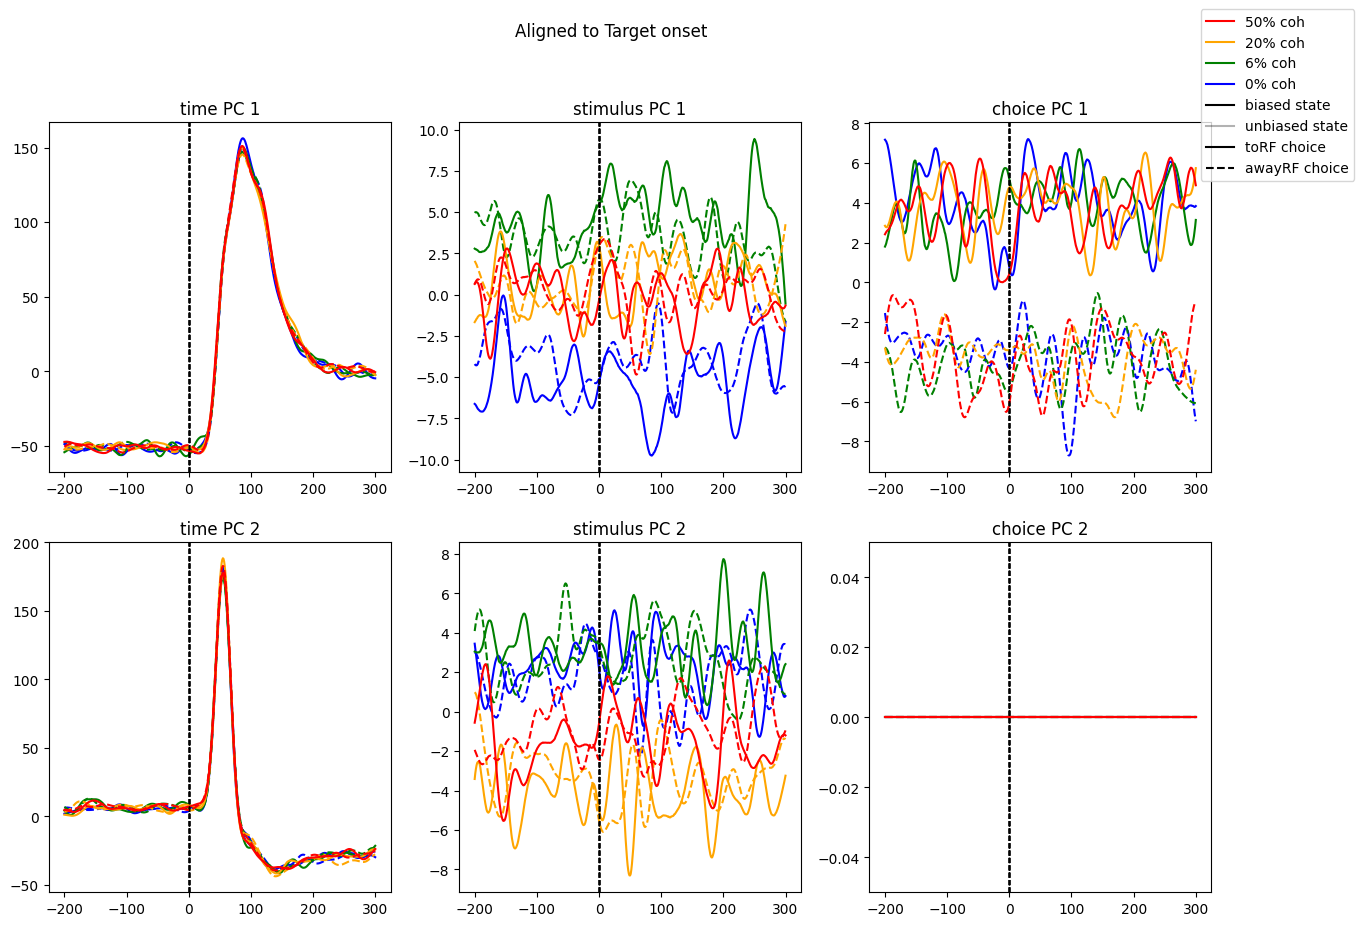

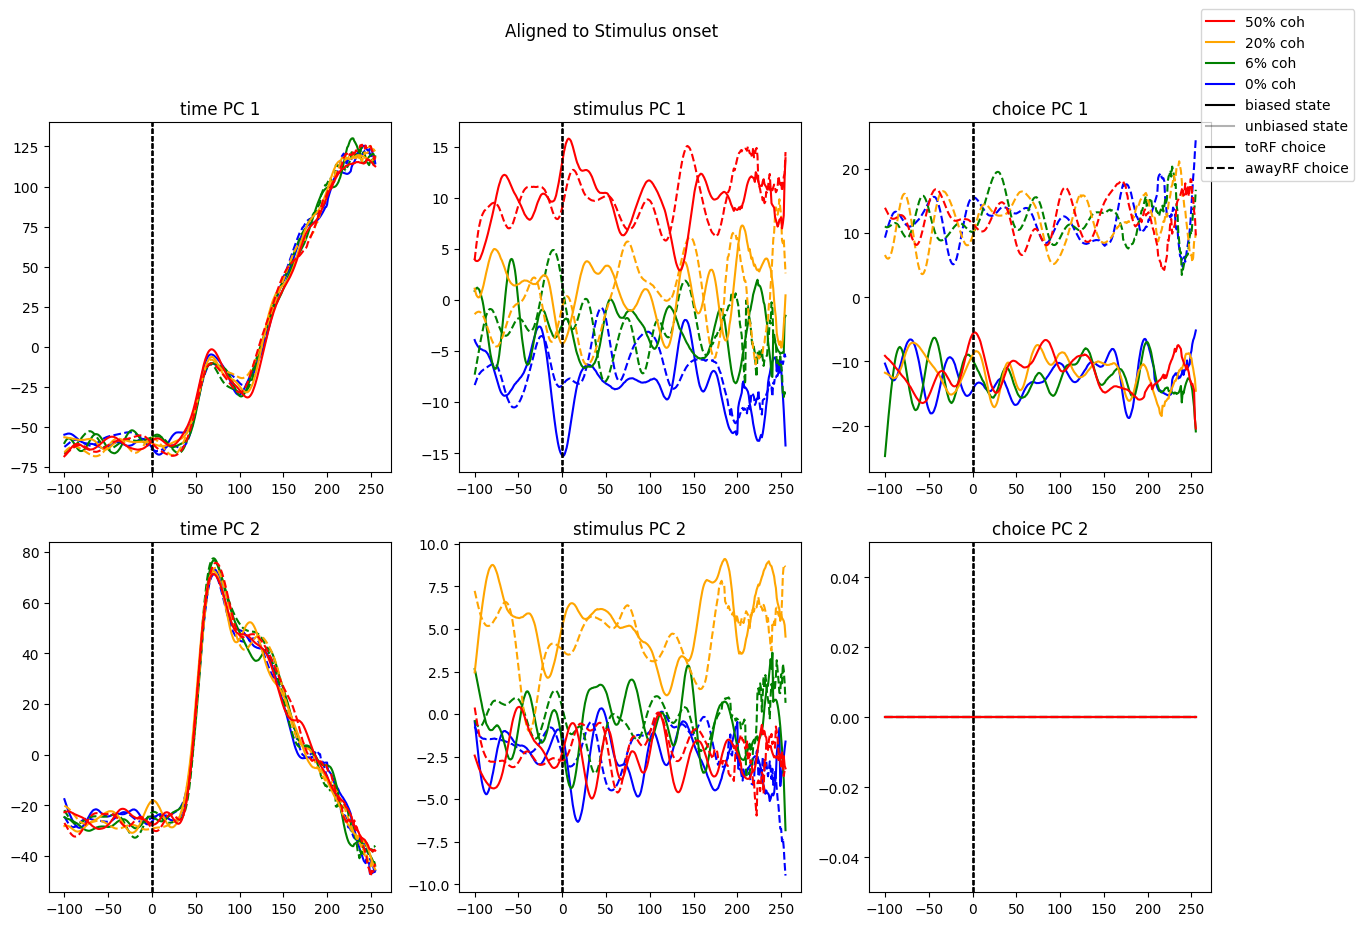

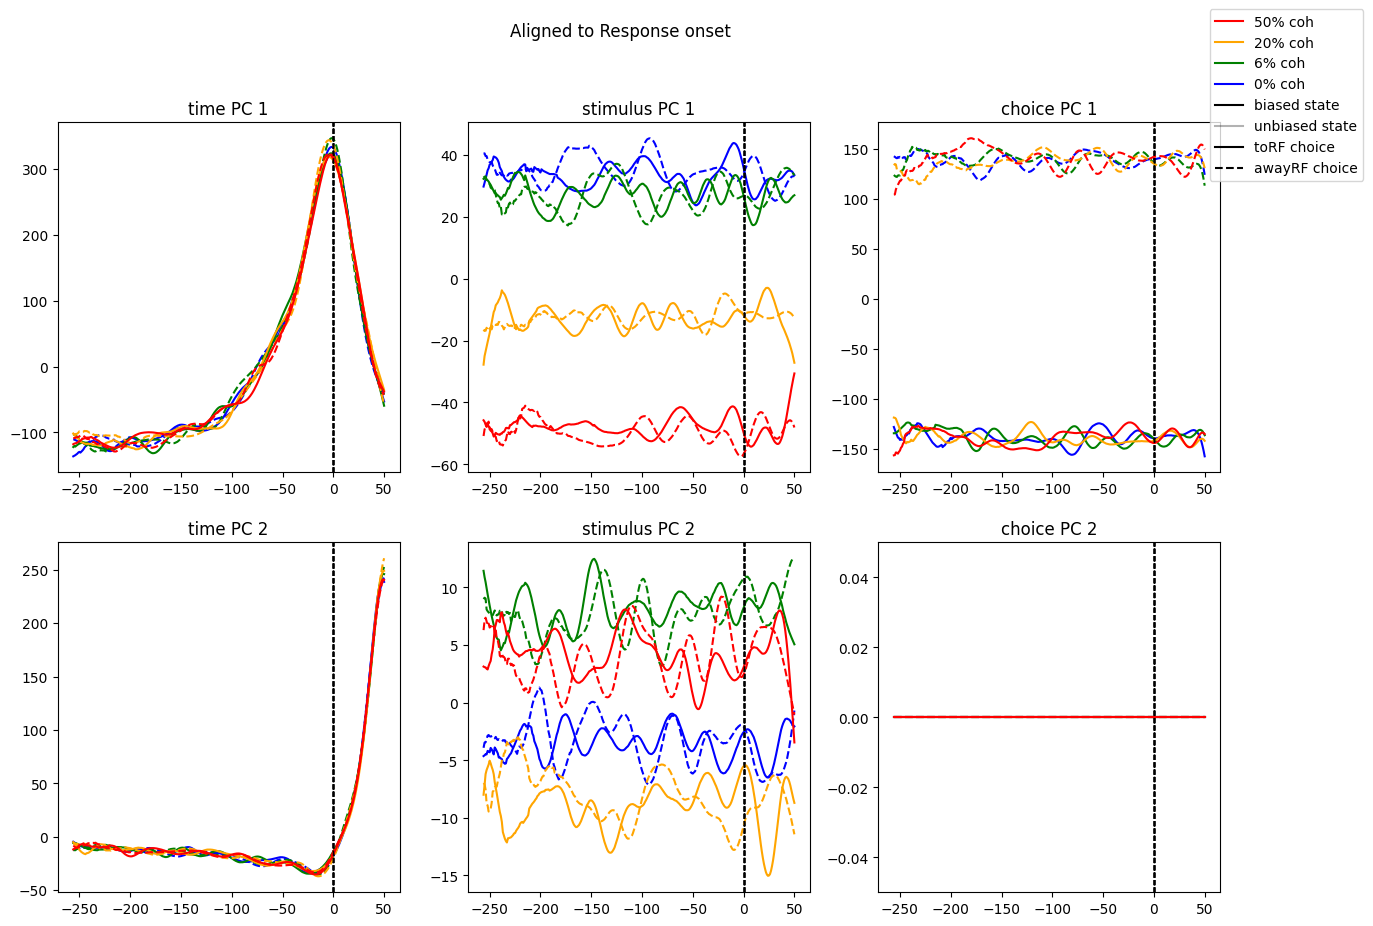

Prior: toRF, State: unbiased


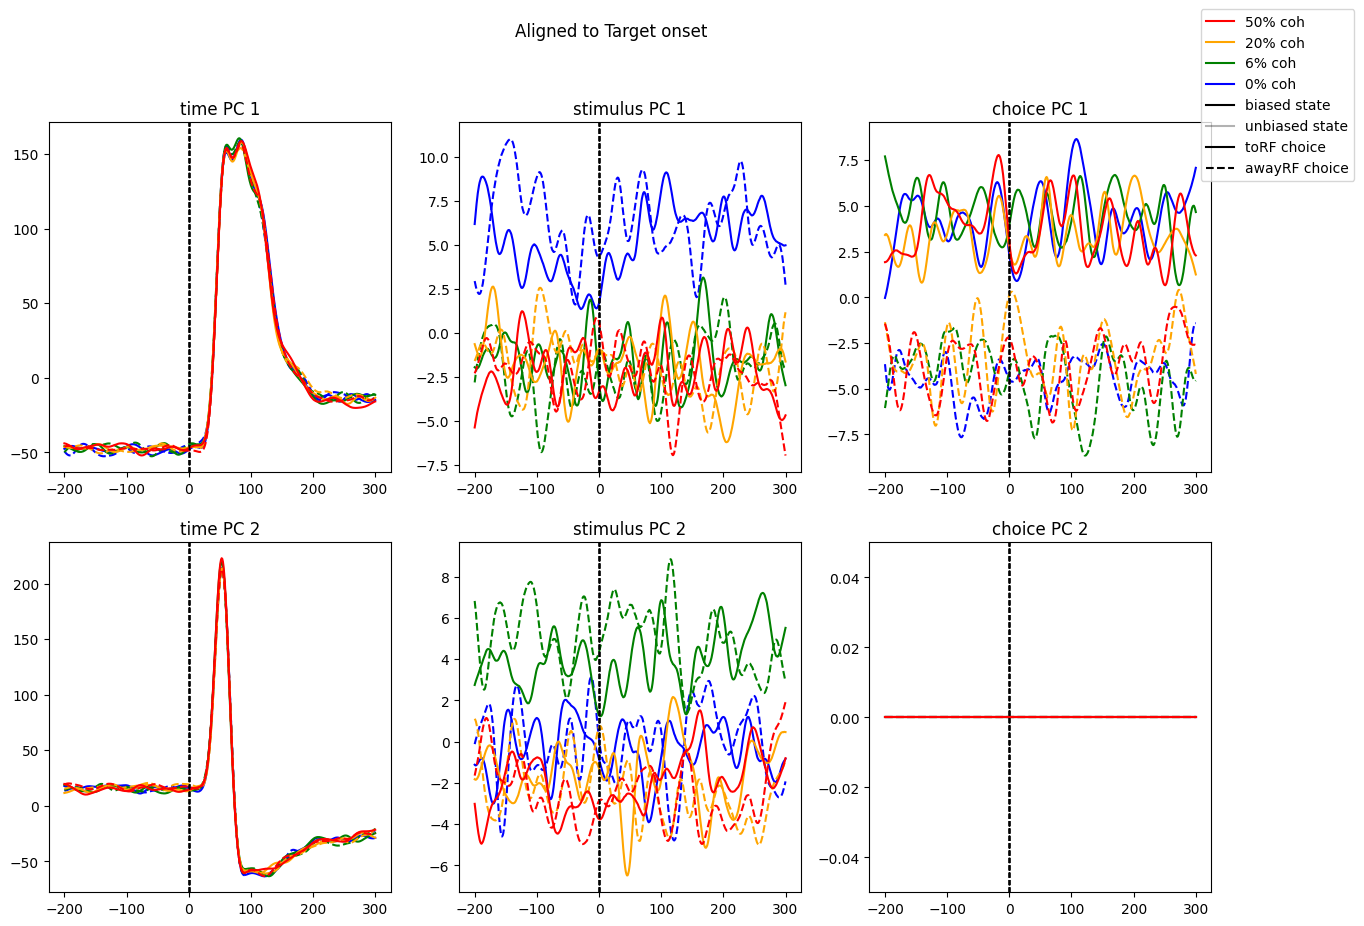

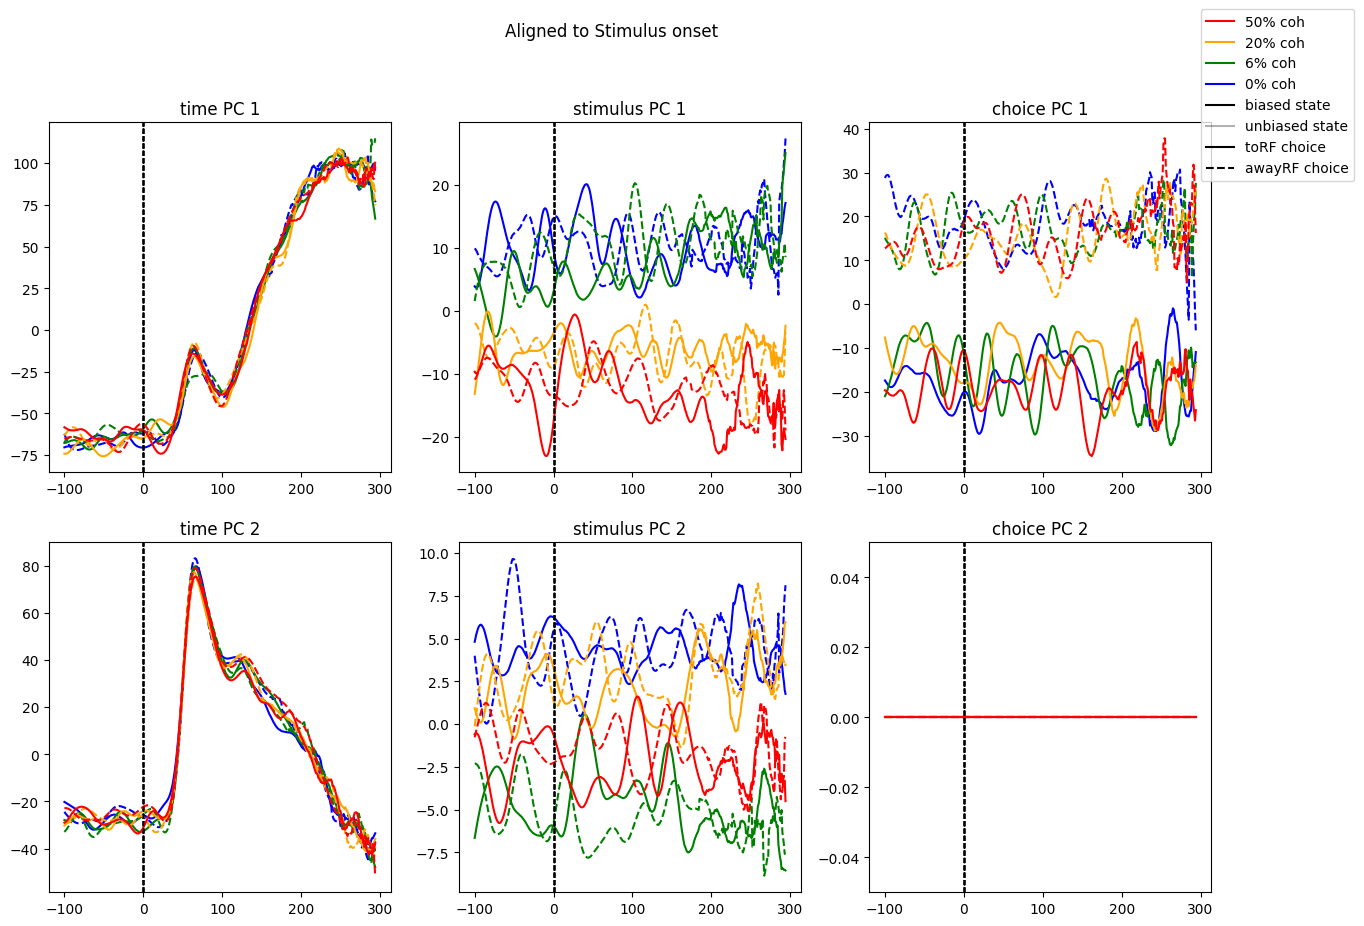

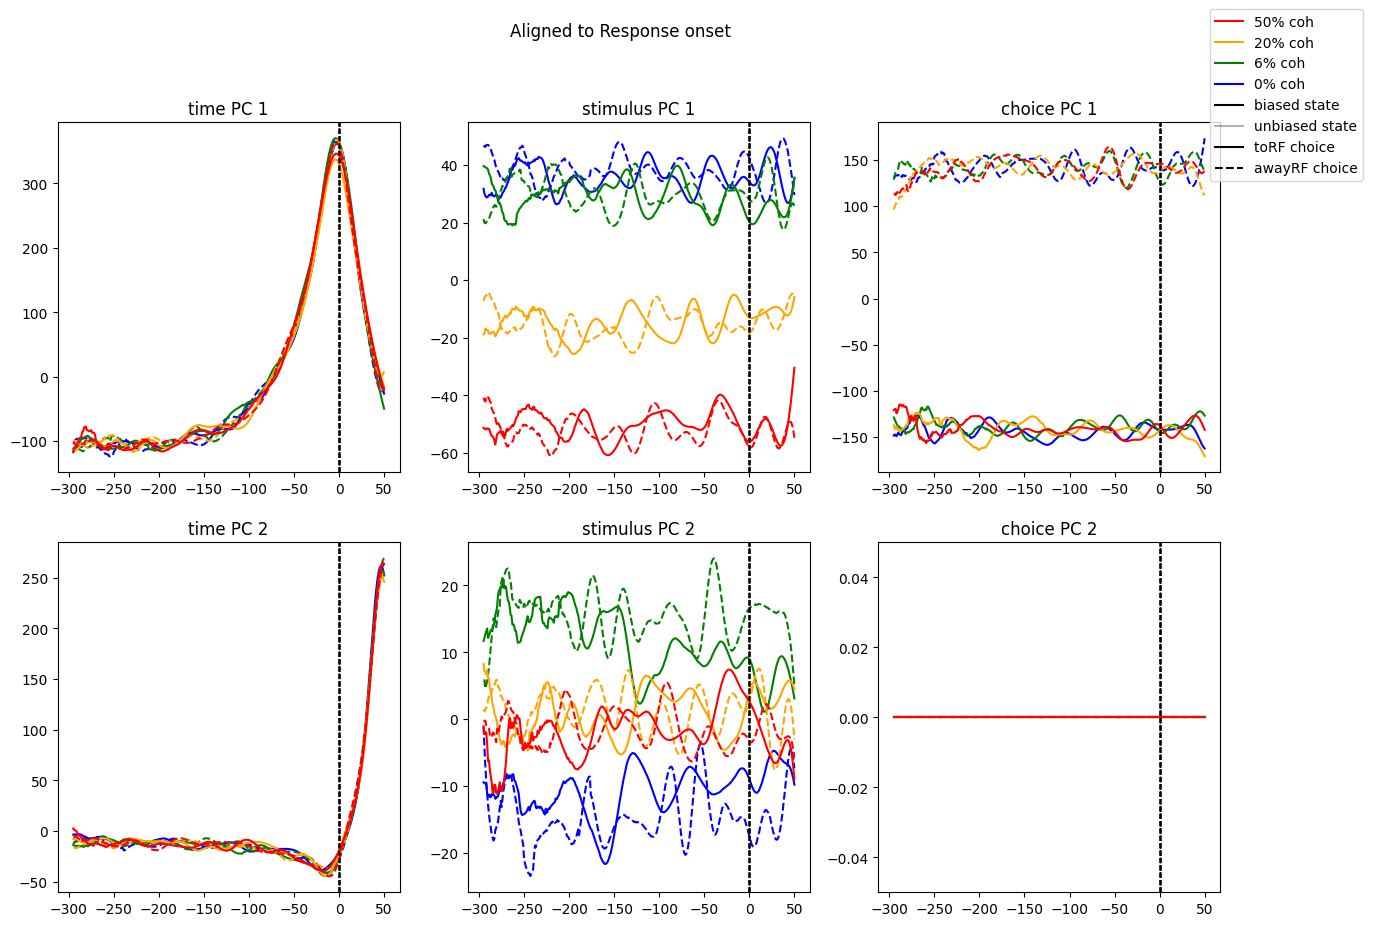

In [71]:
plot_params = {
    "color": {0: "blue", 1: "green", 2: "orange", 3: "red"},
    "lw": {0: 2, 1: 1},
    "linestyle": {0: "-", 1: "--"},
    "opacity": {0: 1, 1: 0.3},
}

plot_dPCA_projection(plot_mean=False, prior="toRF_prior", state="biased_state", ephys_config=ephys_config, dpca_results=dpca_results)
plot_dPCA_projection(plot_mean=False, prior="toRF_prior", state="unbiased_state",ephys_config=ephys_config, dpca_results=dpca_results)


Prior: awayRF, State: biased


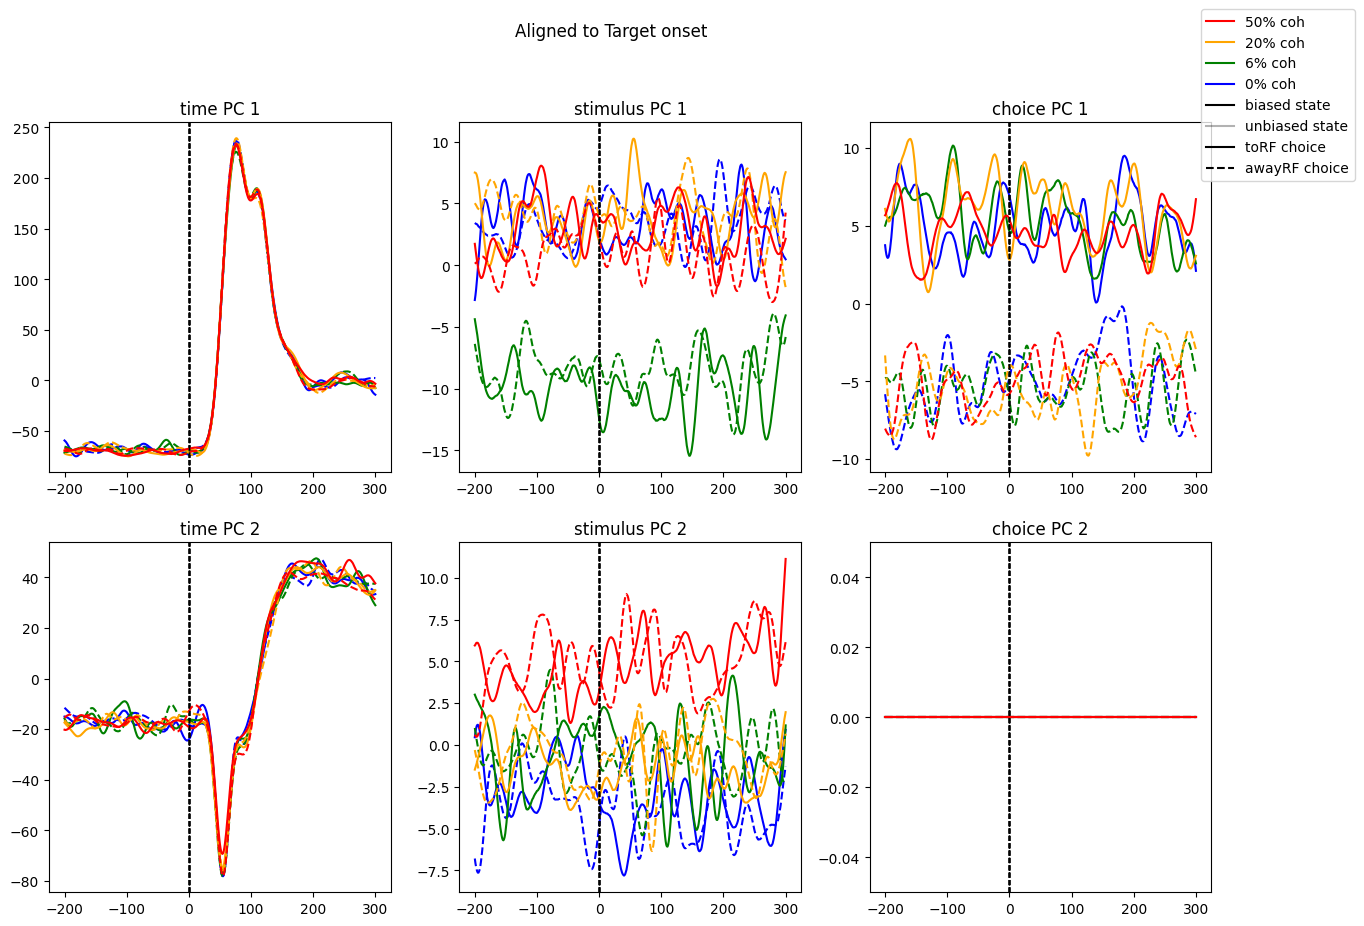

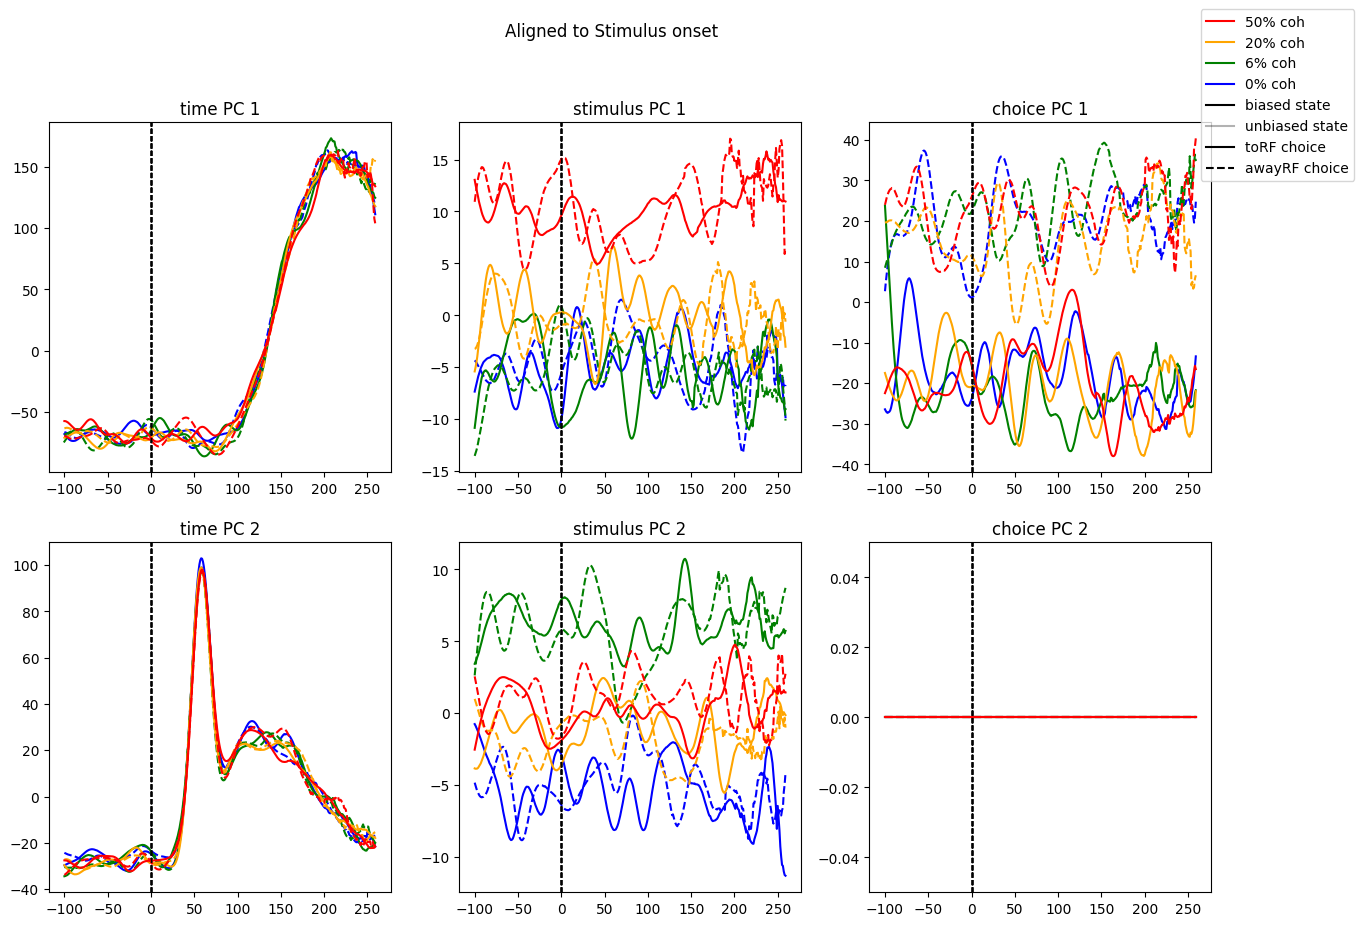

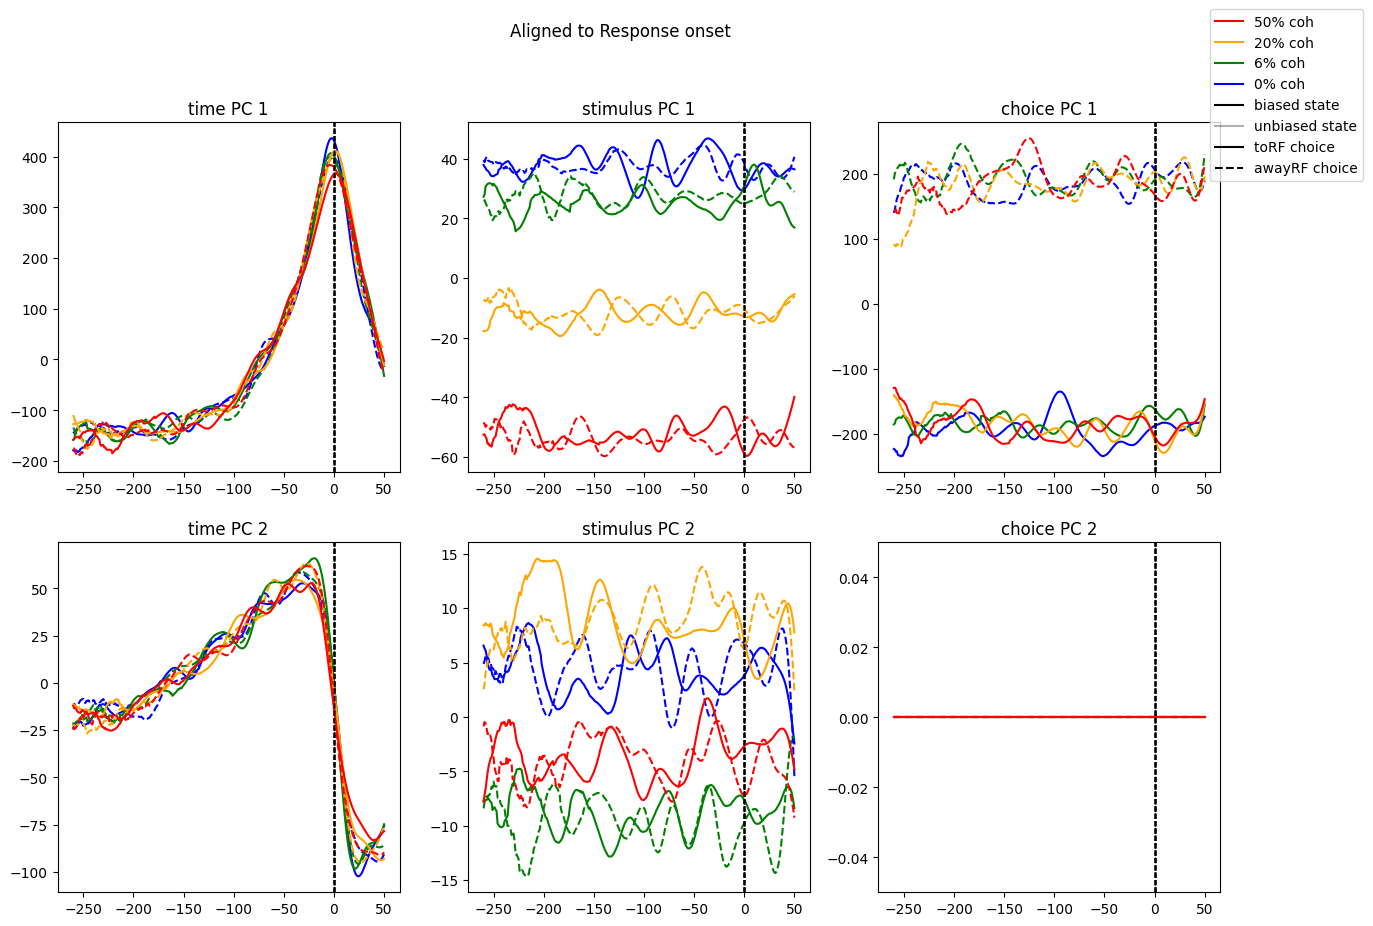

Prior: awayRF, State: unbiased


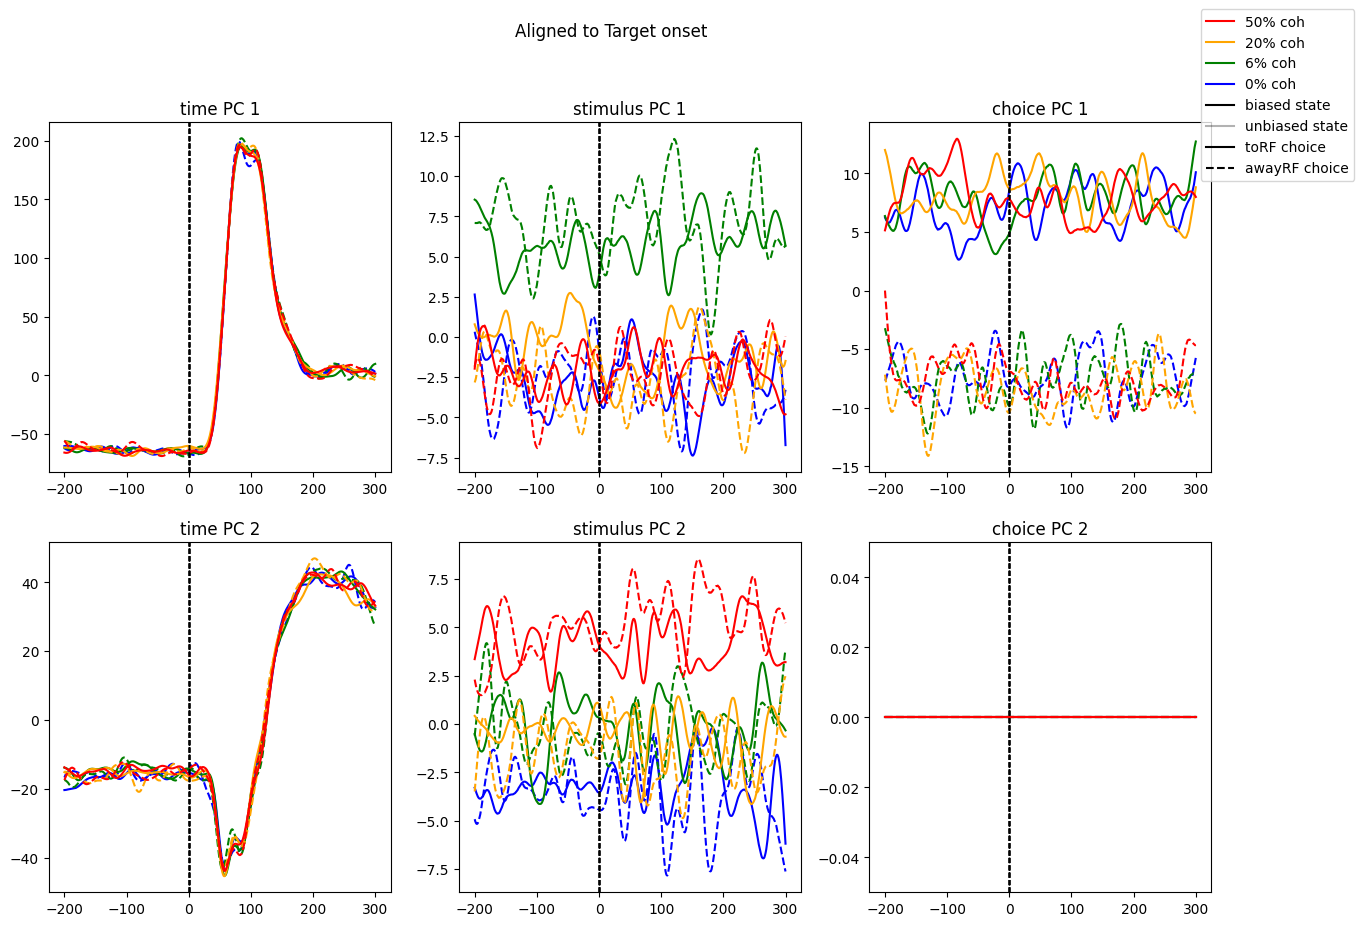

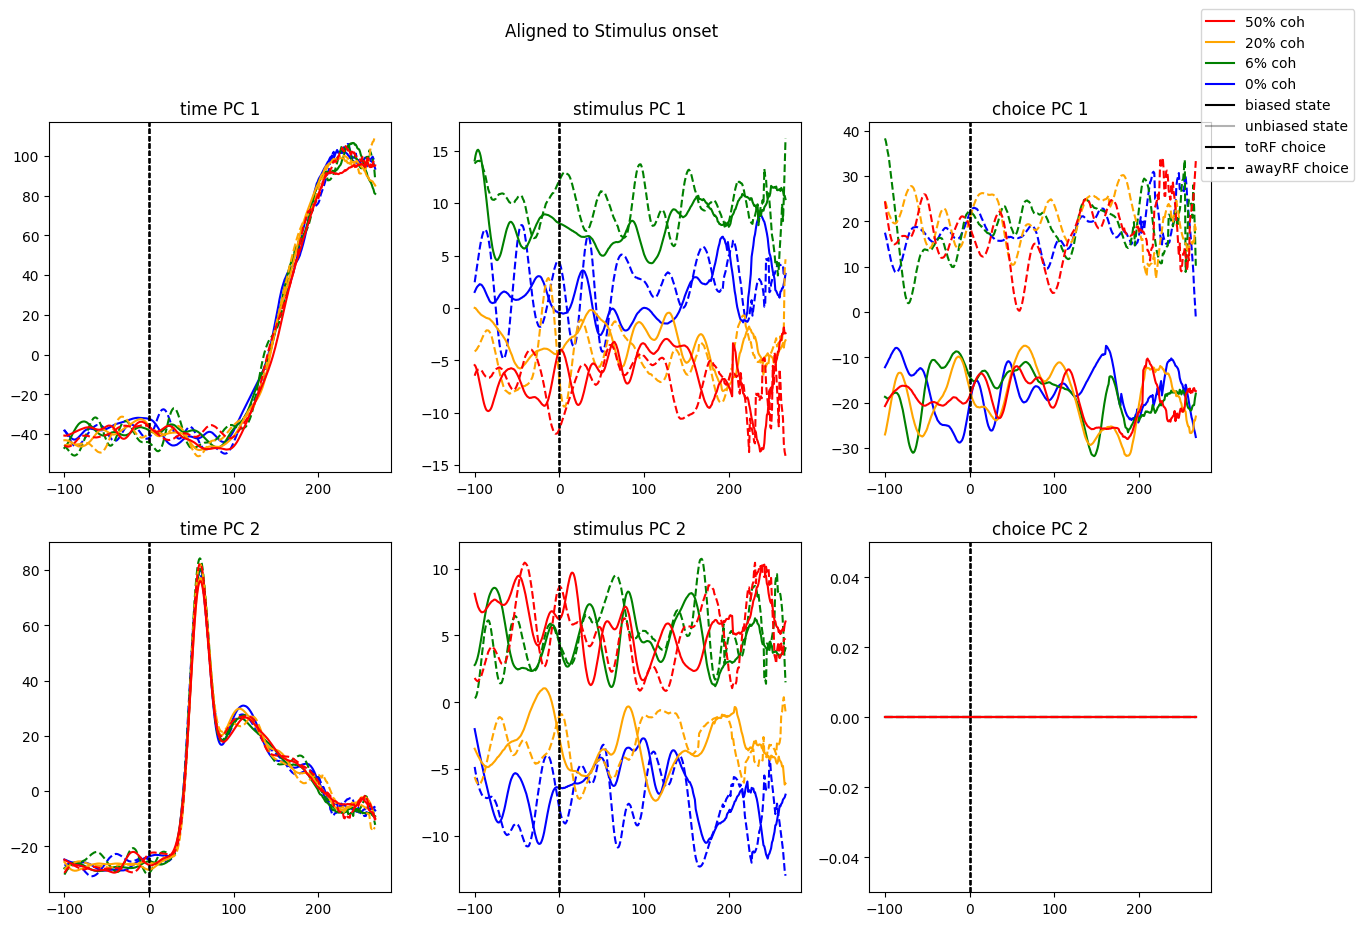

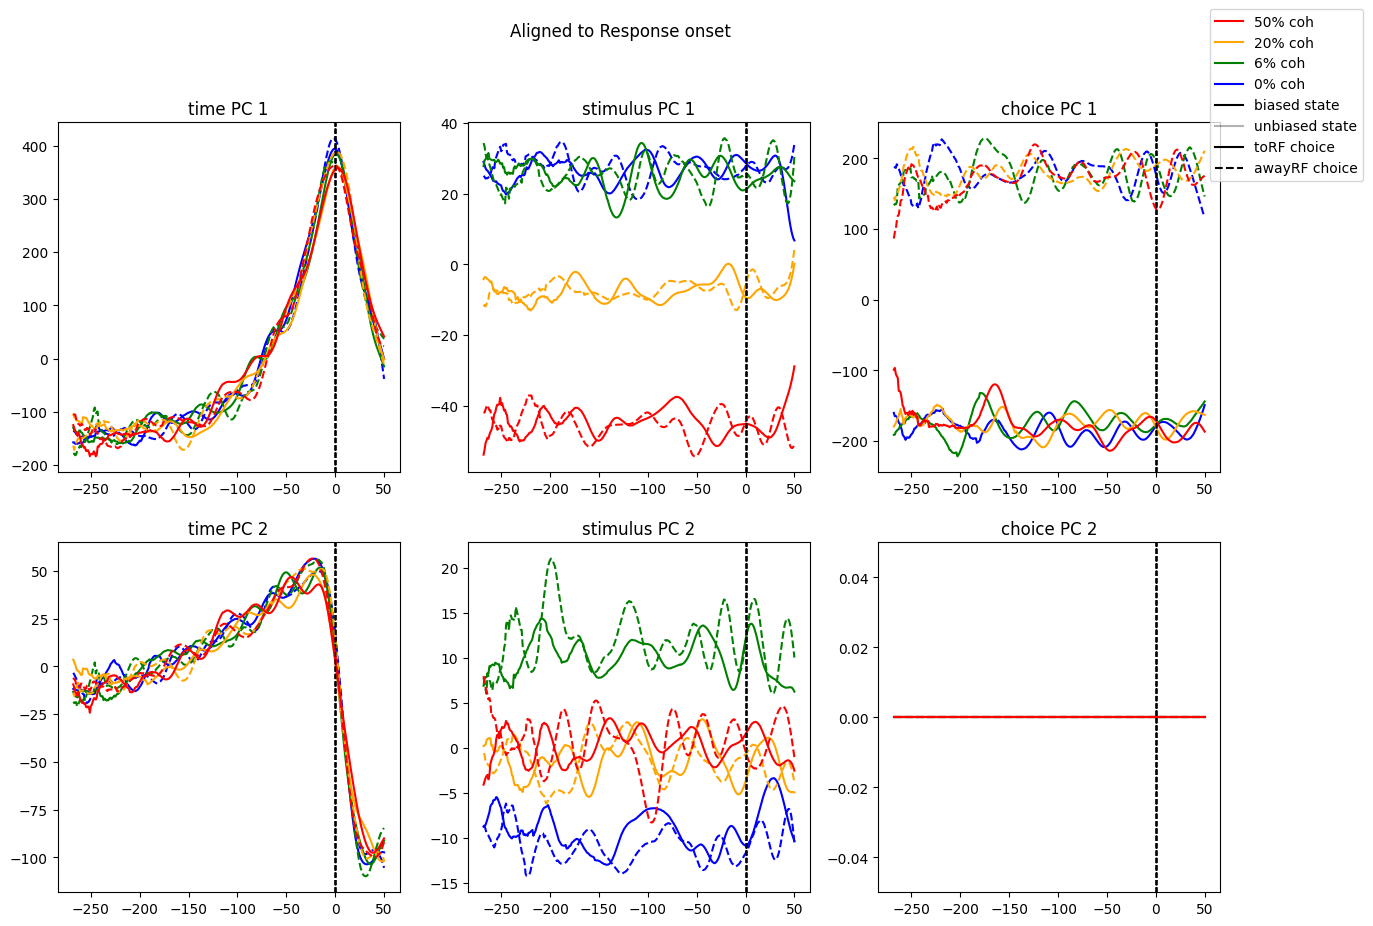

In [72]:
plot_dPCA_projection(plot_mean=False, prior="awayRF_prior", state="biased_state", ephys_config=ephys_config, dpca_results=dpca_results)
plot_dPCA_projection(plot_mean=False, prior="awayRF_prior", state="unbiased_state",ephys_config=ephys_config, dpca_results=dpca_results)

## Project demixed axes on PCA

In [111]:
choice_axis_toRF = {"biased_state":{},"unbiased_state":{}}
choice_axis_awayRF = {"biased_state":{},"unbiased_state":{}}
choice_axis_proj_toRF = {"biased_state":{},"unbiased_state":{}}
choice_axis_proj_awayRF = {"biased_state":{},"unbiased_state":{}}

stimulus_axis_toRF = {"biased_state":{},"unbiased_state":{}}
stimulus_axis_awayRF = {"biased_state":{},"unbiased_state":{}}
stimulus_axis_proj_toRF = {"biased_state":{},"unbiased_state":{}}
stimulus_axis_proj_awayRF = {"biased_state":{},"unbiased_state":{}}

for state in ["biased_state", "unbiased_state"]:
    for alignment in ephys_config["alignment_settings_GP"]:
        choice_axis_toRF[state][alignment] = dpca_results["toRF_prior"][state][alignment]["model"].D['c'][:,0]
        choice_axis_awayRF[state][alignment] = dpca_results["awayRF_prior"][state][alignment]["model"].D['c'][:,0]
        stimulus_axis_toRF[state][alignment] = dpca_results["toRF_prior"][state][alignment]["model"].D['s'][:,0]
        stimulus_axis_awayRF[state][alignment] = dpca_results["awayRF_prior"][state][alignment]["model"].D['s'][:,0]

        choice_axis_proj_toRF[state][alignment] = toRF_pc_weights[alignment][:,:3].T @ choice_axis_toRF[state][alignment]
        choice_axis_proj_awayRF[state][alignment] = awayRF_pc_weights[alignment][:,:3].T @ choice_axis_awayRF[state][alignment]
        stimulus_axis_proj_toRF[state][alignment] = toRF_pc_weights[alignment][:,:3].T @ stimulus_axis_toRF[state][alignment]
        stimulus_axis_proj_awayRF[state][alignment] = awayRF_pc_weights[alignment][:,:3].T @ stimulus_axis_awayRF[state][alignment]

In [138]:
def add_axis_arrow(fig,coord,color='red',dash = "solid",legend=None):

    # normalize vector
    coord = coord / np.linalg.norm(coord)

    # Create the vector line
    line = go.Scatter3d(
        x=[-coord[0], coord[0]],  # Start and end x-coordinates
        y=[-coord[1], coord[1]],  # Start and end y-coordinates
        z=[-coord[2], coord[2]],  # Start and end z-coordinates
        mode='lines',  
        line=dict(color=color, width=6, dash=dash),
        name=legend
    )

    # Create the arrowhead using a Cone
    arrow = go.Cone(
        x=[coord[0]],  # Arrowhead at the endpoint
        y=[coord[1]],  
        z=[coord[2]],  
        u=[coord[0]],  # Vector direction
        v=[coord[1]],  
        w=[coord[2]],  
        sizemode="absolute",
        sizeref=0.2,  # Adjust the size of the arrowhead
        anchor="tail",
        colorscale=[[0, 'red'], [1, 'red']],
        showscale=False
    )

    # Create the figure
    fig.add_trace(line)
    fig.add_trace(arrow)

In [98]:
def angle_between_vectors(A, B):
    # Compute dot product
    dot_product = np.dot(A, B)
    
    # Compute magnitudes (norms) of the vectors
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (norm_A * norm_B)
    
    # Avoid numerical errors (clip value between -1 and 1)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute angle in radians
    theta_rad = np.arccos(cos_theta)
    # Convert to degrees
    theta_deg = np.min((np.degrees(theta_rad), 180-np.degrees(theta_rad)))
    
    return theta_deg

In [169]:
for alignment in ["target_onset", "stimulus_onset", "response_onset"]:
    print(f"Alignment: {alignment.replace('_', ' ').upper()}")
    RF = "toRF"
    print("ToRF Session")
    biased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment]
    unbiased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment]
    state_diff = angle_between_vectors(biased_stim_choice_vec, unbiased_stim_choice_vec)
    print(f"Angle between biased and unbiased state in choice-stimulus plane (degrees): {state_diff}")


    RF = "awayRF"
    print("AwayRF Session")
    biased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment]
    unbiased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment]
    state_diff = angle_between_vectors(biased_stim_choice_vec, unbiased_stim_choice_vec)
    print(f"Angle between biased and unbiased state in choice-stimulus plane (degrees): {state_diff}")
    print("\n")

Alignment: TARGET ONSET
ToRF Session
Angle between biased and unbiased state in choice-stimulus plane (degrees): 47.31603955562529
AwayRF Session
Angle between biased and unbiased state in choice-stimulus plane (degrees): 57.561006286324606


Alignment: STIMULUS ONSET
ToRF Session
Angle between biased and unbiased state in choice-stimulus plane (degrees): 34.68074663324919
AwayRF Session
Angle between biased and unbiased state in choice-stimulus plane (degrees): 77.87768837174143


Alignment: RESPONSE ONSET
ToRF Session
Angle between biased and unbiased state in choice-stimulus plane (degrees): 40.63589884447168
AwayRF Session
Angle between biased and unbiased state in choice-stimulus plane (degrees): 79.69138039565682




### angle between demixed axes

In [162]:
alignment = "stimulus_onset"
print(f"Alignment: {alignment.replace('_', ' ').upper()}\n")

RF = "toRF"
choice_deg = angle_between_vectors(globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment], globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment])
stimulus_deg = angle_between_vectors(globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment], globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment])
stimulus_choice_bias_deg = angle_between_vectors(globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment], globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment])
stimulus_choice_unbias_deg = angle_between_vectors(globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment], globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment])
print("ToRF Session")
print(f"Angle between choice axes (degrees): {choice_deg}")
print(f"Angle between stimulus axes (degrees): {stimulus_deg}")
print(f"Angle between choice and stimulus axes in biased (degrees): {stimulus_choice_bias_deg}")
print(f"Angle between choice and stimulus axes in unbiased (degrees): {stimulus_choice_unbias_deg}")
biased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment]
unbiased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment]
state_diff = angle_between_vectors(biased_stim_choice_vec, unbiased_stim_choice_vec)
print(f"Angle between biased and unbiased state in choice-stimulus plane (degrees): {state_diff}")
print("\n")

RF = "awayRF"
choice_deg = angle_between_vectors(globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment], globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment])
stimulus_deg = angle_between_vectors(globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment], globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment])
stimulus_choice_bias_deg = angle_between_vectors(globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment], globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment])
stimulus_choice_unbias_deg = angle_between_vectors(globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment], globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment])
print("AwayRF Session")
print(f"Angle between choice axes (degrees): {choice_deg}")
print(f"Angle between stimulus axes (degrees): {stimulus_deg}")
print(f"Angle between choice and stimulus axes in biased (degrees): {stimulus_choice_bias_deg}")
print(f"Angle between choice and stimulus axes in unbiased (degrees): {stimulus_choice_unbias_deg}")
biased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment]
unbiased_stim_choice_vec = globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment]
state_diff = angle_between_vectors(biased_stim_choice_vec, unbiased_stim_choice_vec)
print(f"Angle between biased and unbiased state in choice-stimulus plane (degrees): {state_diff}")

Alignment: STIMULUS ONSET

ToRF Session
Angle between choice axes (degrees): 36.06654869537869
Angle between stimulus axes (degrees): 71.36310993910313
Angle between choice and stimulus axes in biased (degrees): 9.443668231174684
Angle between choice and stimulus axes in unbiased (degrees): 44.23224119511346
Angle between biased and unbiased state in choice-stimulus plane (degrees): 34.68074663324919


AwayRF Session
Angle between choice axes (degrees): 52.13752413805494
Angle between stimulus axes (degrees): 10.79243710355589
Angle between choice and stimulus axes in biased (degrees): 52.02099787793394
Angle between choice and stimulus axes in unbiased (degrees): 9.462024407270661
Angle between biased and unbiased state in choice-stimulus plane (degrees): 77.87768837174143


In [170]:
fig = go.Figure()
RF = 'toRF'
add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment],    color = 'brown',legend='Choice Axis')
add_axis_arrow(fig, globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment],  color = 'black',legend='Stimulus Axis')
add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment],  color = 'brown',dash="dash",legend='Choice Axis')
add_axis_arrow(fig, globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment],color = 'black',dash="dash",legend='Stimulus Axis')
# add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment],color = 'brown',legend='Stimulus Axis')
# add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment],color = 'black',dash="dash",legend='Stimulus Axis')

# Set plot labels
fig.update_layout(
    width = 1600,
    height= 1200,
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title="Interactive 3D PCA Projection"
)
fig.show()


fig = go.Figure()
RF = 'awayRF'
add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment],    color = 'brown',legend='Choice Axis')
add_axis_arrow(fig, globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment],  color = 'black',legend='Stimulus Axis')
add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment],  color = 'brown',dash="dash",legend='Choice Axis')
add_axis_arrow(fig, globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment],color = 'black',dash="dash",legend='Stimulus Axis')
# add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["biased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["biased_state"][alignment],color = 'brown',legend='Stimulus Axis')
# add_axis_arrow(fig, globals()[f"choice_axis_proj_{RF}"]["unbiased_state"][alignment] - globals()[f"stimulus_axis_proj_{RF}"]["unbiased_state"][alignment],color = 'black',dash="dash",legend='Stimulus Axis')

# Set plot labels
fig.update_layout(
    width = 1600,
    height= 1200,
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title="Interactive 3D PCA Projection"
)
fig.show()